# 3rd part: Image and texts, with EasyCLEF

In [13]:
import os
import ParserEasyClef
import ParserCACM
import modeles
import numpy as np
import query
import evaluation
import clusterings
import matplotlib.pyplot as plt
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

# Constants:

srcFolder = "easyCLEF08/"

# File that contains all documents
srcFile = "easyCLEF08_text.txt"
# File that contains all relevances for queries
relevantsFile = "easyCLEF08_gt.txt"
# File that contains all queries
qryFile = "easyCLEF08_query.txt"

easyClef_txt = os.path.join(srcFolder, srcFile)
easyClef_qry = os.path.join(srcFolder, qryFile)
easyClef_rel = os.path.join(srcFolder, relevantsFile)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import indexation 
import TextRepresenter

parser = ParserEasyClef.ParserEasyClef()
stemmer =  TextRepresenter.PorterStemmer()
idx = indexation.InMemoryIndex(easyClef_txt, 
                               parser, 
                               stemmer)
all_docs_id = idx.getDocsID()
print("All docs ID (%d):" % len(all_docs_id))
print(all_docs_id)

allQueries = {}
qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
while qry is not None:
    allQueries[int(qry.getID())] = qry
    qry = qp.nextQuery()
print("All qry ids (%d):" % len(allQueries))
print(allQueries.keys())


All docs ID (2256):
['23700', '7346', '27687', '9755', '35621', '31852', '39180', '11341', '16851', '32038', '24385', '23397', '8765', '11269', '39624', '26043', '32457', '31499', '4344', '20022', '14620', '8174', '39057', '23928', '10728', '4849', '35885', '6629', '36035', '10344', '35789', '9968', '3210', '37393', '24054', '18392', '37228', '19260', '37896', '6924', '1531', '38161', '39657', '34140', '6775', '7979', '1591', '7728', '39447', '40175', '35678', '15099', '39788', '32250', '26912', '30971', '30922', '31543', '8182', '2024', '39190', '16574', '38247', '31487', '4569', '32648', '16709', '31848', '21420', '39852', '2677', '4078', '38011', '9529', '39789', '9144', '6455', '38152', '4759', '31857', '37290', '2693', '4406', '38246', '13331', '37596', '40426', '31389', '19322', '38013', '9996', '20348', '2470', '7998', '2308', '25648', '6297', '2219', '2277', '39547', '3513', '10195', '22989', '37101', '37226', '26133', '39088', '19138', '18817', '6904', '39159', '34162', '9840'

## Test baseline for some queries

In [50]:
modele_vect = modeles.Vectoriel(idx, modeles.BinaryWeighter(idx))
modele_vect_tfidf = modeles.Vectoriel(idx, modeles.TfidfWeighter(idx))
wantedId = [5, 3]
print("Searching for query", wantedId)
for qryID in wantedId :
    qry = allQueries[qryID]
    print("Query")
    print(qry)
    qry_repr = stemmer.getTextRepresentation(qry.getText())
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    n = 20
    print("Precision at %d docs:" % n)
    print(eval_precAtN.eval(n, verbose=True))
    print("Cluster Recall at %d docs:" % n)
    print(eval_CRAtN.eval(n, verbose=True))

    print(20 * '-')
    
print("Done.")


Searching for query [5, 3]
Query
Query {id=5, txt='animal swimming. Relevant images will show one or more animals (fish, birds, reptiles, etc.) swimming in a body of water. Images of people swimming in water are not relevant. Images of animals that are not swimming are not not relevant.
', relevances=[1515, 2007, 2285, 2764, 2913, 3090, 3166, 3248, 3660, 4218, 4219, 4969, 4975, 4979, 4993, 5011, 5012, 6294, 6297, 6342, 6556, 8458, 9149, 10738, 12608, 13170, 13183, 15027, 15172, 15405, 15645, 16638, 16952, 19108, 26625, 30783, 30817, 30822, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30843, 30844, 30845, 30846, 30863, 30865, 30866, 30867, 30868, 30869, 31072, 37447, 37448, 37449, 37450, 38269, 38270, 38271]}
Precision at 20 docs:
Result:  15405
Relevant, found docs = 1
Result:  3090
Relevant, found docs = 2
Result:  30828
Relevant, found docs = 3
Result:  30825
Relevant, found docs = 4
Result:  3525
Result:  38271
Relevant, found docs = 5
Result:  30827
Relevant, found docs 

## Test of clustering

In [66]:
kmeans = clusterings.KMeansClustering()
prCluster = modeles.PRClustering(idx, modele_vect, kmeans, nDocs=100)

wantedId = [5, 3]
print("Searching for query", wantedId)
for qryID in wantedId:
    qry = allQueries[qryID]
    print("Query")
    print(qry)
    qry_repr = stemmer.getTextRepresentation(qry.getText())
    ranking = prCluster.getRanking(qry_repr, Nclusters=None, verbose=True)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    n = 20
    print("Precision at %d docs:" % n)
    print(eval_precAtN.eval(n, verbose=True))
    print("Cluster Recall at %d docs:" % n)
    print(eval_CRAtN.eval(n, verbose=True))

    print(20 * '-')
    
print("Done.")


Searching for query [5, 3]
Query
Query {id=5, txt='animal swimming. Relevant images will show one or more animals (fish, birds, reptiles, etc.) swimming in a body of water. Images of people swimming in water are not relevant. Images of animals that are not swimming are not not relevant.
', relevances=[1515, 2007, 2285, 2764, 2913, 3090, 3166, 3248, 3660, 4218, 4219, 4969, 4975, 4979, 4993, 5011, 5012, 6294, 6297, 6342, 6556, 8458, 9149, 10738, 12608, 13170, 13183, 15027, 15172, 15405, 15645, 16638, 16952, 19108, 26625, 30783, 30817, 30822, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30843, 30844, 30845, 30846, 30863, 30865, 30866, 30867, 30868, 30869, 31072, 37447, 37448, 37449, 37450, 38269, 38270, 38271]}

Base ranking: ['15405', '3090', '30828', '30825', '3525', '38271', '30827', '30869', '30866', '30824', '30865', '30822', '30830', '30817', '30831', '3166', '30826', '30863', '2285', '26625', '4218', '9331', '17836', '35644', '19114', '4224', '16767', '23052', '30845', '

## Plot for one query:

Searching for query 3
Query:  Query {id=3, txt='religious statue in the foreground. Relevant images will show a statue of one (or more) religious figures such as gods, angels, prophets etc. from any kind of religion in the foreground. Non-religious statues like war memorials or monuments are not relevant. Images with statues that are not the focus of the image (like the front view of church with many small statues) are not relevant. The statues of Easter Island are not relevant as they do not have any religious background.
', relevances=[28, 3147, 4531, 4533, 4759, 4815, 4895, 4896, 4900, 6501, 10657, 10999, 14520, 15330, 15973, 16819, 16993, 19135, 19194, 19198, 19211, 19259, 20356, 20357, 22777, 23108, 25966, 30011, 35678, 35780, 35782, 35783, 36035, 36036]}


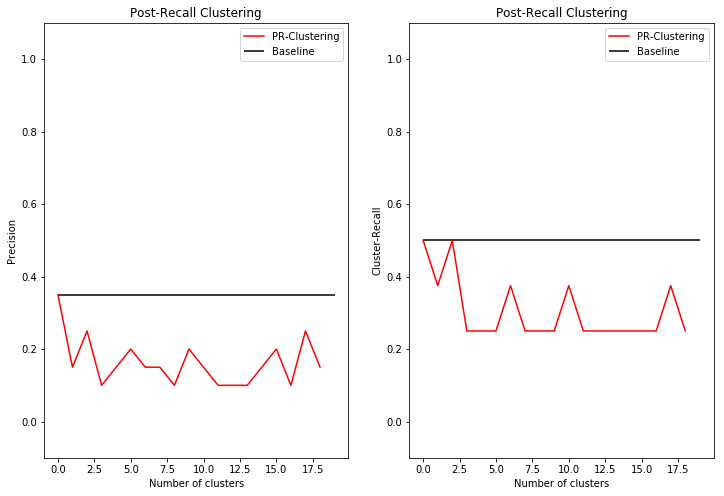

Done.


In [63]:
rand_qry_id = np.random.choice(all_qry_id)
print("Searching for query", rand_qry_id)
at = 20
nClusterRange = range(1, at)

# Searching the query
qp = query.QueryParserCACM(easyClef_qry, easyClef_rel)
qry = qp.nextQuery()
while qry is not None and int(qry.getID()) != rand_qry_id:
    qry = qp.nextQuery()
    
print("Query: ",qry)
qry_repr = stemmer.getTextRepresentation(qry.getText())

# Compute the baseline scores:
dict_scores = modele_vect.getScores(qry_repr)
list_scores = [(docId, score) for docId, score in dict_scores.items()]
irlist = evaluation.IRList(qry, list_scores)
eval_precAtN = evaluation.PrecisionNDocuments(irlist)
eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
baseline_prec = eval_precAtN.eval(at, verbose=False)
baseline_CR   = eval_CRAtN.eval(at, verbose=False)
#print("Baseline: prec=%f, CR=%f" % (baseline_prec, baseline_CR))

# Compute the post-retrieval clustering:
precisions = []
CRs = []
for nCluster in nClusterRange:
    ranking = prCluster.getRanking(qry_repr, Nclusters=nCluster)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    eval_precAtN = evaluation.PrecisionNDocuments(irlist)
    eval_CRAtN = evaluation.ClusterRecallNDocuments(irlist)
    prec = eval_precAtN.eval(at)
    CR = eval_CRAtN.eval(at, verbose=False)
    precisions.append(prec)
    CRs.append(CR)
    #print("%d clusters: prec=%f, CR=%f" % (nCluster, prec, CR))

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.hlines(baseline_prec, xmin=0, xmax=at-1, label="Baseline")
plt.plot(precisions, "r", label="PR-Clustering")
plt.legend()
plt.title("Post-Recall Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Precision")
plt.ylim([-0.1, 1.1])

plt.subplot(1,2,2)
plt.hlines(baseline_CR, xmin=0, xmax=at-1, label="Baseline")
plt.plot(CRs, "r", label="PR-Clustering")
plt.legend()
plt.title("Post-Recall Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("Cluster-Recall")
plt.ylim([-0.1, 1.1])

plt.show()

print("Done.")

# Benchmark

In [64]:
at = 20
benchmarkQueries = np.random.choice(list(allQueries.values()), size=10, replace=False)

prCluster.setNDocs(100)
baseline_prec = []
baseline_CR = []
prCluster_prec = []
prCluster_CR = []

print("Query | Base prec. | PRC prec. | Delta  | Base CR | PRC CR | Delta")
print(70*'=')

for qry in benchmarkQueries:
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    basePrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    baseCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    baseline_prec.append(basePrec)
    baseline_CR.append(baseCR)
    
    # Compute the post-retrieval clustering:
    ranking = prCluster.getRanking(qry_repr, Nclusters=None, maxClusters=20)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    prclusterPrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    prclusterCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    prCluster_prec.append(prclusterPrec)
    prCluster_CR.append(prclusterCR)
    print("%5s |    %.3f   |   %.3f   | %6.3f |  %.3f  | %.3f  | %6.3f" % 
          (qry.getID(), basePrec, prclusterPrec, prclusterPrec-basePrec, 
                        baseCR, prclusterCR, prclusterCR-baseCR))

        
print(70*'=')
meanBasePrec = np.mean(baseline_prec)
meanBaseCR = np.mean(baseline_CR)
meanPrcPrec = np.mean(prCluster_prec)
meanPrcCR = np.mean(prCluster_CR)
print("Mean  |    %.3f   |   %.3f   | %6.3f |  %.3f  | %.3f  | %6.3f" % 
          (meanBasePrec, meanPrcPrec, meanPrcPrec-meanBasePrec,
           meanBaseCR, meanPrcCR, meanPrcCR-meanBaseCR))    
print("Done.")

Query | Base prec. | PRC prec. | Delta  | Base CR | PRC CR | Delta
   29 |    1.000   |   0.850   | -0.150 |  1.000  | 1.000  |  0.000
   10 |    0.250   |   0.300   |  0.050 |  0.087  | 0.130  |  0.043
   24 |    0.050   |   0.050   |  0.000 |  0.250  | 0.250  |  0.000
   39 |    0.150   |   0.050   | -0.100 |  0.500  | 0.250  | -0.250
   53 |    1.000   |   0.850   | -0.150 |  1.000  | 0.500  | -0.500
   34 |    0.650   |   0.550   | -0.100 |  0.143  | 0.286  |  0.143
   16 |    0.600   |   0.400   | -0.200 |  0.261  | 0.217  | -0.043
   21 |    1.000   |   1.000   |  0.000 |  0.875  | 0.875  |  0.000
   31 |    0.900   |   0.850   | -0.050 |  0.500  | 0.500  |  0.000
   56 |    0.300   |   0.250   | -0.050 |  0.400  | 0.600  |  0.200
Mean  |    0.590   |   0.515   | -0.075 |  0.502  | 0.461  | -0.041
Done.


## With MeanShift

In [49]:

at = 20
benchmarkQueries = np.random.choice(list(allQueries.values()), size=10, replace=False)

prCluster.setCluster(clusterings.MeanShiftClustering())
prCluster.setNDocs(100)

baseline_prec = []
baseline_CR = []
prCluster_prec = []
prCluster_CR = []

print("Query | Base prec. | PRC prec. | Delta  | Base CR | PRC CR | Delta")
print(70*'=')

for qry in benchmarkQueries:
    qry_repr = stemmer.getTextRepresentation(qry.getText())

    # Compute the baseline scores:
    dict_scores = modele_vect.getScores(qry_repr)
    list_scores = [(docId, score) for docId, score in dict_scores.items()]
    irlist = evaluation.IRList(qry, list_scores)
    basePrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    baseCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    baseline_prec.append(basePrec)
    baseline_CR.append(baseCR)
    
    # Compute the post-retrieval clustering:
    ranking = prCluster.getRanking(qry_repr, Nclusters=None, maxClusters=20)
    irlist = evaluation.IRList(qry, scores=None, ranking=ranking)
    prclusterPrec = evaluation.PrecisionNDocuments(irlist).eval(at)
    prclusterCR = evaluation.ClusterRecallNDocuments(irlist).eval(at)
    prCluster_prec.append(prclusterPrec)
    prCluster_CR.append(prclusterCR)
    print("%5s |    %.3f   |   %.3f   | %6.3f |  %.3f  | %.3f  | %6.3f" % 
          (qry.getID(), basePrec, prclusterPrec, prclusterPrec-basePrec, 
                        baseCR, prclusterCR, prclusterCR-baseCR))

        
print(70*'=')
meanBasePrec = np.mean(baseline_prec)
meanBaseCR = np.mean(baseline_CR)
meanPrcPrec = np.mean(prCluster_prec)
meanPrcCR = np.mean(prCluster_CR)
print("Mean  |    %.3f   |   %.3f   | %6.3f |  %.3f  | %.3f  | %6.3f" % 
          (meanBasePrec, meanPrcPrec, meanPrcPrec-meanBasePrec,
           meanBaseCR, meanPrcCR, meanPrcCR-meanBaseCR))    
print("Done.")

Query | Base prec. | PRC prec. | Delta  | Base CR | PRC CR | Delta
   13 |    0.350   |   0.300   | -0.050 |  0.333  | 0.222  | -0.111
   35 |    0.950   |   0.850   | -0.100 |  0.625  | 0.625  |  0.000
   52 |    0.900   |   0.800   | -0.100 |  0.714  | 0.714  |  0.000
   17 |    0.350   |   0.350   |  0.000 |  0.300  | 0.300  |  0.000
   54 |    0.667   |   0.611   | -0.056 |  1.000  | 1.000  |  0.000
   34 |    0.650   |   0.650   |  0.000 |  0.143  | 0.143  |  0.000
   15 |    0.800   |   0.750   | -0.050 |  0.714  | 0.714  |  0.000
   60 |    0.950   |   0.800   | -0.150 |  1.000  | 1.000  |  0.000
   56 |    0.300   |   0.300   |  0.000 |  0.400  | 0.400  |  0.000
   55 |    1.000   |   0.950   | -0.050 |  0.167  | 0.333  |  0.167
Mean  |    0.692   |   0.636   | -0.056 |  0.540  | 0.545  |  0.006
Done.
